# ⚽ Predicting Football Player Market Value (Regression)

**Author:** Ali Mohamed Ibrahim  
**Date:** 2/9/2025  
**Domain:** Sports Analytics (Football/Soccer)  
**Notebook Type:** End-to-End Regression

> **Executive Summary:**  
> **Goal:** Predict players’ market value (€) from the 2025 SoFIFA snapshot.  
> **Best Model:** RandomForest (300 trees, log-target + smearing).  
> **Test Performance:** R² **0.932**, RMSE **€1.94M**, MAE **€0.30M**.  
> **Key Drivers:** release_clause_eur, overall_rating, potential, wage_eur, age, club_rating.  
> **Ablation (no release clause):** R² **0.875**, RMSE **€2.65M** → release clause is a strong business signal.  
> **Deliverables:** Trained pipeline, metrics, predictions, and an inference template packaged for handover.  
> **Recommendations:** Use the provided template for scoring new data; keep the release clause when available; retrain periodically as new seasons are released.



## 🎯 Project Charter

### Problem
Estimating fair **player market value (€)** is complex and opaque; values depend on skills, age, potential, wages, club context, and league.

### Objective
Build a **robust, explainable regression model** that predicts market value from player attributes using the 2025 SoFIFA snapshot.

### Success Criteria (KPIs)
- **Test R² ≥ 0.93**
- **Test RMSE ≤ €2.1M**
- **Test MAE ≤ €0.35M**
- Clear feature importance and slice analysis; packaged model + inference template delivered

### Scope
- **In scope:** Data prep/cleaning, EDA, feature engineering, model training & tuning, evaluation, interpretation, client-ready deliverables  
- **Out of scope:** Production deployment, real-time APIs, continuous monitoring

### Stakeholders
Sports analysts, scouting teams, football data enthusiasts, hiring managers.

### Assumptions & Risks
- Data is a **SoFIFA 2025-06-03** snapshot; values reflect that point in time  
- Potential league/region bias due to roster composition  
- **Leakage risk:** features like *release_clause_eur* may encode business knowledge—kept for accuracy; ablation reported for transparency


## 🗂️ Data & Access

**Source:** Kaggle — SoFIFA snapshot  
**Dataset ID:** `aniss7/fifa-player-data-from-sofifa-2025-06-03`  
**Access:** KaggleHub (latest snapshot).  
**File loaded:** `player-data-full-2025-june.csv` (version `2025-06-03`)

### Target & Features Used
- **Target:** `value_eur` (parsed from `value`; model trains on `log_value_eur`, reported in € with smearing back-transform).
- **Core predictors:**  
  `overall_rating`, `potential`, `age`, `height_cm`, `weight_kg`,  
  `wage_eur`, `club_rating`, `release_clause_eur` (+ `release_clause_missing` flag),  
  `primary_position`, `position_group`, `preferred_foot`, `club_league_name`.

> **Note:** Granular skill attributes (e.g., finishing, dribbling, sprint_speed) are **not available** in this snapshot (100% missing) and were excluded.


In [3]:
import os
import re
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("aniss7/fifa-player-data-from-sofifa-2025-06-03")
print("Path to dataset files:", path)

all_files = []
for root, _, files in os.walk(path):
    for f in files:
        all_files.append(os.path.join(root, f))

rel_files = [os.path.relpath(p, path) for p in all_files]
print("\nFiles found in dataset folder:")
for p in rel_files:
    print("  -", p)

csv_candidates = [p for p in all_files if p.lower().endswith(".csv")]

if not csv_candidates:
    import zipfile
    zip_archives = [p for p in all_files if p.lower().endswith(".zip")]
    if zip_archives:
        print("\nNo CSVs found initially. Extracting ZIP archives...")
        for z in zip_archives:
            try:
                with zipfile.ZipFile(z, "r") as zf:
                    zf.extractall(os.path.dirname(z))
                    print("  Extracted:", os.path.relpath(z, path))
            except zipfile.BadZipFile:
                print("  Warning: Bad ZIP file skipped:", os.path.relpath(z, path))
        all_files = []
        for root, _, files in os.walk(path):
            for f in files:
                all_files.append(os.path.join(root, f))
        csv_candidates = [p for p in all_files if p.lower().endswith(".csv")]

def _score_csv(fp: str) -> int:
    name = os.path.basename(fp).lower()
    score = 0
    if "player" in name: score += 5
    if "sofifa" in name: score += 3
    if "fifa" in name: score += 2
    if "data" in name: score += 1
    if "25" in name: score += 1
    return score

if not csv_candidates:
    raise FileNotFoundError(
        "No CSV files were found in the dataset folder. "
        "Please check the listed files above."
    )

csv_candidates_sorted = sorted(csv_candidates, key=lambda p: (-_score_csv(p), os.path.basename(p)))
chosen_csv = csv_candidates_sorted[0]
print("\nSelected CSV:", os.path.relpath(chosen_csv, path))

try:
    data = pd.read_csv(chosen_csv, low_memory=False)
except UnicodeDecodeError:
    data = pd.read_csv(chosen_csv, low_memory=False, encoding="latin-1")

print("\nShape:", data.shape)
display(data.head())
print("\n.info():")
data.info()
print("\n.describe(include='all') top rows:")
display(data.describe(include="all").transpose().head(20))


Path to dataset files: C:\Users\NEW TOP\.cache\kagglehub\datasets\aniss7\fifa-player-data-from-sofifa-2025-06-03\versions\1

Files found in dataset folder:
  - player-data-full-2025-june.csv

Selected CSV: player-data-full-2025-june.csv

Shape: (18205, 76)


,player_id,version,name,full_name,description,image,height_cm,weight_kg,dob,positions,...,composure,defensive_awareness,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,play_styles
0,231866,2025-06-03,Rodri -,Rodrigo Hernández Cascante,Rodri (born 22 June 1996) is a Spanish footbal...,https://cdn.sofifa.net/players/231/866/25_120.png,190,82,1996-06-22,"CDM,CM",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,209331,2025-06-03,Mohamed Salah Hamed Ghaly -,Mohamed Salah Hamed Ghalyمحمد صلاح,"Mohamed Salah (Mohamed Salah Hamed Ghaly, born...",https://cdn.sofifa.net/players/209/331/25_120.png,175,72,1992-06-15,"RM,RW",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,252371,2025-06-03,Jude Victor William Bellingham -,Jude Victor William Bellingham,Jude Bellingham (Jude Victor William Bellingha...,https://cdn.sofifa.net/players/252/371/25_120.png,186,75,2003-06-29,"CAM,CM",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,239085,2025-06-03,Erling Braut Håland -,Erling Braut Håland,"Erling Haaland (Erling Braut Håland, born 21 J...",https://cdn.sofifa.net/players/239/085/25_120.png,195,94,2000-07-21,ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,238794,2025-06-03,Vini Jr. -,Vinicius José Paixão de Oliveira Junior,Vini Jr. (Vinicius José Paixão de Oliveira Jun...,https://cdn.sofifa.net/players/238/794/25_120.png,176,73,2000-07-12,"LW,ST",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18205 entries, 0 to 18204
Data columns (total 76 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  18205 non-null  int64  
 1   version                    18205 non-null  object 
 2   name                       18205 non-null  object 
 3   full_name                  18205 non-null  object 
 4   description                18205 non-null  object 
 5   image                      18205 non-null  object 
 6   height_cm                  18205 non-null  int64  
 7   weight_kg                  18205 non-null  int64  
 8   dob                        18205 non-null  object 
 9   positions                  18205 non-null  object 
 10  overall_rating             18205 non-null  int64  
 11  potential                  18205 non-null  int64  
 12  value                      18205 non-null  object 
 13  wage                       18205 non

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_id,18205.0,NaN,NaN,NaN,216070.596155,66424.785066,18115.0,208835.0,239367.0,260669.0,280200.0
version,18205,1,2025-06-03,18205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,18205,18071,Altimira -,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full_name,18205,18152,Nick Olij,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,18205,18166,Tomáš Holeš (born 31 March 1993) is a Czech fo...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image,18205,18166,https://cdn.sofifa.net/players/251/116/25_120.png,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height_cm,18205.0,NaN,NaN,NaN,181.974952,6.859854,156.0,177.0,182.0,187.0,210.0
weight_kg,18205.0,NaN,NaN,NaN,75.244164,6.8967,47.0,70.0,75.0,80.0,105.0
dob,18205,6284,1996-02-29,186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
positions,18205,483,CB,2430,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 🔎 Data Understanding

### 1) Dataset Snapshot
- **Local Path:** `C:\Users\NEW TOP\.cache\kagglehub\datasets\aniss7\fifa-player-data-from-sofifa-2025-06-03\versions\1`
- **File Loaded:** `player-data-full-2025-june.csv`
- **Raw Shape:** **18,205 × 76**  · **Snapshot/Version:** `2025-06-03`
- **Modeling Table (after cleaning):** **18,120 rows × 15 features**

### 2) Columns Used in Modeling
- **Target:** `value_eur` → train on `log_value_eur` (back-transform with smearing for € reporting)
- **Numeric predictors:** `overall_rating`, `potential`, `age`, `height_cm`, `weight_kg`, `wage_eur`, `club_rating`, `release_clause_eur` (+ `release_clause_missing`)
- **Categorical predictors:** `primary_position`, `position_group`, `preferred_foot`, `club_league_name`
- **Excluded:** Fine-grained skill attributes (e.g., `finishing`, `dribbling`, `sprint_speed`) — **100% missing in this snapshot**

### 3) Guiding Questions
- What is the distribution of **market value** (and **log value**) and where are the outliers?
- How do **overall_rating**, **potential**, **age**, **wage**, and **club_rating** relate to value?
- How do values differ by **position group** and **league**?
- Any data quality concerns (parsing of money fields/dates, remaining missingness)?


In [4]:

import re
from datetime import datetime
import numpy as np
import pandas as pd


def parse_euro_money(x):
    """
    Convert Sofifa-style money strings to float euros.
    Examples: '€1.1M' -> 1_100_000, '€650K' -> 650_000, '€0' -> 0
    Returns np.nan for unparseable inputs.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = s.replace("€", "").replace(",", "").replace(" ", "").upper()
    if s in {"-", "", "NAN", "NONE"}:
        return np.nan
    if s == "0" or s == "0.0":
        return 0.0

    m = re.match(r"^([0-9]*\.?[0-9]+)\s*([KMB])?$", s)
    if not m:

        try:
            return float(s)
        except Exception:
            return np.nan

    num = float(m.group(1))
    suf = m.group(2)
    if suf == "K":
        num *= 1_000
    elif suf == "M":
        num *= 1_000_000
    elif suf == "B":
        num *= 1_000_000_000
    return float(num)


def derive_age_from_dob(dob_series: pd.Series, snapshot_date: pd.Timestamp) -> pd.Series:
    """Compute integer age (years) at snapshot_date from YYYY-MM-DD dob strings."""
    dob_dt = pd.to_datetime(dob_series, errors="coerce", utc=False)
   
    age_years = (snapshot_date - dob_dt).dt.days / 365.25
    return np.floor(age_years).astype("Int64")


def extract_primary_position(positions_series: pd.Series) -> pd.Series:
    """Take the first position from a comma-separated string like 'CDM,CM' → 'CDM'."""
    def _first(pos):
        if pd.isna(pos):
            return np.nan
        first = str(pos).split(",")[0].strip().upper()
        return first if first else np.nan
    return positions_series.apply(_first)


def map_position_group(primary_pos: pd.Series) -> pd.Series:
    """Map primary position to a coarse group: GK / DEF / MID / FWD / UNKNOWN."""
    DEF = {"CB", "LB", "RB", "LWB", "RWB"}
    MID = {"CDM", "CM", "CAM", "LM", "RM"}
    FWD = {"ST", "CF", "LW", "RW"}

    def _group(p):
        if pd.isna(p):
            return "UNKNOWN"
        p = p.upper()
        if p == "GK":
            return "GK"
        if p in DEF:
            return "DEF"
        if p in MID:
            return "MID"
        if p in FWD:
            return "FWD"
        return "UNKNOWN"

    return primary_pos.apply(_group)



if "version" in data.columns and not data["version"].isna().all():
    try:
        snapshot_str = data["version"].mode().iloc[0]
        SNAPSHOT_DATE = pd.to_datetime(snapshot_str, errors="coerce")
        if pd.isna(SNAPSHOT_DATE):
            SNAPSHOT_DATE = pd.Timestamp("2025-06-03")
    except Exception:
        SNAPSHOT_DATE = pd.Timestamp("2025-06-03")
else:
    SNAPSHOT_DATE = pd.Timestamp("2025-06-03")

print(f"[INFO] Using snapshot date: {SNAPSHOT_DATE.date()}")

data = data.copy()

if "value" in data.columns:
    data["value_eur"] = data["value"].apply(parse_euro_money)
else:
    data["value_eur"] = np.nan

if "wage" in data.columns:
    data["wage_eur"] = data["wage"].apply(parse_euro_money)
else:
    data["wage_eur"] = np.nan

if "release_clause" in data.columns:
    data["release_clause_eur"] = data["release_clause"].apply(parse_euro_money)

if "dob" in data.columns:
    data["age"] = derive_age_from_dob(data["dob"], SNAPSHOT_DATE)
else:
    data["age"] = pd.Series([pd.NA] * len(data), dtype="Int64")

if "positions" in data.columns:
    data["primary_position"] = extract_primary_position(data["positions"])
    data["position_group"] = map_position_group(data["primary_position"])
else:
    data["primary_position"] = np.nan
    data["position_group"] = "UNKNOWN"

preview_cols = [
    col for col in [
        "player_id", "name", "full_name",
        "overall_rating", "potential",
        "value", "value_eur", "wage", "wage_eur", "release_clause", "release_clause_eur",
        "dob", "age", "height_cm", "weight_kg",
        "positions", "primary_position", "position_group",
        "club_name", "club_league_name", "club_rating",
        "preferred_foot", "weak_foot", "body_type"
    ] if col in data.columns
]

print("\n[PREVIEW] Selected columns (first 10 rows):")
display(data[preview_cols].head(10))

missing_pct = (
    data.isna()
        .mean()
        .sort_values(ascending=False)
        .to_frame("missing_ratio")
)
missing_pct["missing_%"] = (missing_pct["missing_ratio"] * 100).round(2)
print("\n[MISSINGNESS] Top 20 columns by missing percentage:")
display(missing_pct.head(20))

def nunique_safe(series):
    try:
        return series.nunique(dropna=True)
    except Exception:
        return np.nan

cardinality_cols = [c for c in [
    "primary_position", "position_group", "positions",
    "preferred_foot", "club_name", "club_league_name", "body_type"
] if c in data.columns]

cardinality = {
    c: nunique_safe(data[c]) for c in cardinality_cols
}
card_df = pd.DataFrame.from_dict(cardinality, orient="index", columns=["n_unique"]).sort_values("n_unique", ascending=False)

print("\n[CARDINALITY] Unique counts for selected categoricals:")
display(card_df)

n_value_missing = data["value_eur"].isna().sum() if "value_eur" in data.columns else len(data)
n_wage_missing = data["wage_eur"].isna().sum() if "wage_eur" in data.columns else len(data)

print(f"\n[NOTES] value_eur missing: {n_value_missing} / {len(data)} "
      f"({(n_value_missing/len(data))*100:.2f}%)")
print(f"[NOTES] wage_eur missing:  {n_wage_missing} / {len(data)} "
      f"({(n_wage_missing/len(data))*100:.2f}%)")

print("\n[DECISIONS] For the next step, we will:")
print(" - Use `value_eur` as target (log-transform optional).")
print(" - Start with predictors: overall_rating, potential, age, height_cm, weight_kg, "
      "preferred_foot, primary_position/position_group, club_rating, and selected club context.")
print(" - Exclude granular skill columns that are entirely missing in this snapshot.")


[INFO] Using snapshot date: 2025-06-03

[PREVIEW] Selected columns (first 10 rows):


,player_id,name,full_name,overall_rating,potential,value,value_eur,wage,wage_eur,release_clause,...,weight_kg,positions,primary_position,position_group,club_name,club_league_name,club_rating,preferred_foot,weak_foot,body_type
0,231866,Rodri -,Rodrigo Hernández Cascante,91,91,€115.5M,115500000.0,€440K,440000.0,€213.7M,...,82,"CDM,CM",CDM,MID,Manchester City,Premier League,85.0,Right,4,Normal (185+)
1,209331,Mohamed Salah Hamed Ghaly -,Mohamed Salah Hamed Ghalyمحمد صلاح,91,91,€104M,104000000.0,€350K,350000.0,€192.4M,...,72,"RM,RW",RM,MID,Liverpool,Premier League,84.0,Left,3,Unique
2,252371,Jude Victor William Bellingham -,Jude Victor William Bellingham,90,94,€174.5M,174500000.0,€280K,280000.0,€370.8M,...,75,"CAM,CM",CAM,MID,Real Madrid,La Liga,85.0,Right,4,Normal (170-185)
3,239085,Erling Braut Håland -,Erling Braut Håland,90,92,€157M,157000000.0,€270K,270000.0,€302.2M,...,94,ST,ST,FWD,Manchester City,Premier League,85.0,Left,3,Unique
4,238794,Vini Jr. -,Vinicius José Paixão de Oliveira Junior,90,94,€171.5M,171500000.0,€340K,340000.0,€364.4M,...,73,"LW,ST",LW,FWD,Real Madrid,La Liga,85.0,Right,4,Lean (170-185)
5,231747,Kylian Mbappé Lottin -,Kylian Mbappé Lottin,90,93,€160M,160000000.0,€380K,380000.0,€340M,...,75,"ST,LW",ST,FWD,Real Madrid,La Liga,85.0,Right,4,Unique
6,203376,Virgil van Dijk -,Virgil van Dijk,90,90,€77.5M,77500000.0,€220K,220000.0,€143.4M,...,92,CB,CB,DEF,Liverpool,Premier League,84.0,Right,3,Unique
7,202126,Harry Edward Kane -,Harry Edward Kane,90,90,€117.5M,117500000.0,€170K,170000.0,€193.9M,...,86,ST,ST,FWD,FC Bayern München,Bundesliga,84.0,Right,4,Unique
8,256630,Florian Richard Wirtz -,Florian Richard Wirtz,89,92,€143.5M,143500000.0,€125K,125000.0,€247.5M,...,71,"CAM,ST",CAM,MID,Bayer 04 Leverkusen,Bundesliga,83.0,Right,4,Normal (170-185)
9,212831,Alisson -,Alisson Ramsés Becker,89,89,€54.5M,54500000.0,€130K,130000.0,€100.8M,...,91,GK,GK,GK,Liverpool,Premier League,84.0,Right,3,Unique



[MISSINGNESS] Top 20 columns by missing percentage:


,missing_ratio,missing_%
defensive_awareness,1.0,100.0
composure,1.0,100.0
gk_reflexes,1.0,100.0
play_styles,1.0,100.0
standing_tackle,1.0,100.0
sliding_tackle,1.0,100.0
gk_diving,1.0,100.0
gk_handling,1.0,100.0
crossing,1.0,100.0
finishing,1.0,100.0



[CARDINALITY] Unique counts for selected categoricals:


,n_unique
club_name,659
positions,483
club_league_name,42
primary_position,12
body_type,10
position_group,4
preferred_foot,2



[NOTES] value_eur missing: 0 / 18205 (0.00%)
[NOTES] wage_eur missing:  0 / 18205 (0.00%)

[DECISIONS] For the next step, we will:
 - Use `value_eur` as target (log-transform optional).
 - Start with predictors: overall_rating, potential, age, height_cm, weight_kg, preferred_foot, primary_position/position_group, club_rating, and selected club context.
 - Exclude granular skill columns that are entirely missing in this snapshot.


## 🧹 Data Cleaning Plan & Modeling Dataset Definition

### 1) Key Findings
- **Target usable:** `value_eur` → **0% missing**
- **Wage usable:** `wage_eur` → **0% missing**
- **Skill sub-attributes:** 100% missing in this snapshot → **excluded**
- **Positions & club context:** available; minor gaps handled

### 2) Target Specification
- **Target column:** `value_eur` (EUR)
- **Modeling target:** `log_value_eur = log1p(value_eur)`
- **Reporting:** back-transform to € using **smearing correction**

### 3) Core Predictors (v1)
| Category | Columns |
|---|---|
| Ability | `overall_rating`, `potential` |
| Demographics | `age` (from `dob`), `height_cm`, `weight_kg` |
| Contract/Financial | `wage_eur`, `release_clause_eur` *(optional)* |
| Role | `primary_position`, `position_group` |
| Club context | `club_rating` (num), `club_league_name` (cat) |
| Footedness | `preferred_foot` *(Left/Right; `weak_foot` optional)* |

### 4) Data Quality Actions
- **Money fields:** parsed to numeric (€, done)
- **Age:** derived from `dob` using snapshot date (2025-06-03, done)
- **Categoricals:** one-hot encode `primary_position`, `position_group`, `preferred_foot`, `club_league_name`
- **Missing values:**  
  - Drop rows missing any **critical** predictors (ratings, age, wage, positions, club_rating)  
  - `release_clause_eur`: median impute + optional missing flag

### 5) Outliers & Transforms
- Use **log1p** target to reduce skew; no trimming needed for v1
- Scale numerics for linear models; trees don’t require scaling

### 6) Modeling Dataset (v1)
- **Target:** `log_value_eur` (keep `value_eur` for reporting)
- **Numerics:** `overall_rating`, `potential`, `age`, `height_cm`, `weight_kg`, `wage_eur`, `club_rating`, `release_clause_eur`
- **Categoricals:** `primary_position`, `position_group`, `preferred_foot`, `club_league_name`
- **Dropped:** fully-missing skills/GK metrics, high-cardinality `club_name`, IDs/URLs/text blobs

### 7) Leakage Check
- Exclude any post-snapshot or market-derived fields beyond `release_clause_eur`
- `version` used only for dating; **excluded** from features


In [5]:

import numpy as np
import pandas as pd

assert "value_eur" in data.columns, "Expected 'value_eur'—run the previous parsing cell first."
assert "overall_rating" in data.columns and "potential" in data.columns, "Core rating columns missing."
assert "age" in data.columns, "Expected derived 'age'—run the previous parsing cell first."
assert "primary_position" in data.columns and "position_group" in data.columns, "Position columns missing."

target_col = "value_eur"

numeric_cols = [
    "overall_rating", "potential", "age",
    "height_cm", "weight_kg",
    "wage_eur", "club_rating",
    "release_clause_eur",  
]

categorical_cols = [
    "primary_position", "position_group",
    "preferred_foot", "club_league_name",
    # "club_name",  # (can revisit with target encoding)
]


numeric_cols   = [c for c in numeric_cols if c in data.columns]
categorical_cols = [c for c in categorical_cols if c in data.columns]

cols_to_keep = [target_col] + numeric_cols + categorical_cols

working = data[cols_to_keep].copy()


for col in ["height_cm", "weight_kg"]:
    if col in working.columns:
        med = working[col].median(skipna=True)
        working[col] = working[col].fillna(med)

if "release_clause_eur" in working.columns:
    working["release_clause_missing"] = working["release_clause_eur"].isna().astype(int)
    rc_median = working["release_clause_eur"].median(skipna=True)
    working["release_clause_eur"] = working["release_clause_eur"].fillna(rc_median)

for c in categorical_cols:
    working[c] = working[c].astype("category")

critical_cols = [target_col, "overall_rating", "potential", "age", "wage_eur", "primary_position", "position_group"]
critical_cols = [c for c in critical_cols if c in working.columns]

n_before = len(working)
working = working.dropna(subset=critical_cols)
n_after_drop_crit = len(working)

if "club_rating" in working.columns:
    working = working.dropna(subset=["club_rating"])
n_after_drop_club = len(working)

working["log_value_eur"] = np.log1p(working["value_eur"])

def _missing_table(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().mean().to_frame("missing_ratio")
    miss["missing_%"] = (miss["missing_ratio"] * 100).round(2)
    return miss.sort_values("missing_ratio", ascending=False)

print("── Data Retention Report ─────────────────────────────")
print(f"Initial rows:                {n_before:,}")
print(f"After dropping critical NaN: {n_after_drop_crit:,}  (−{n_before - n_after_drop_crit:,})")
print(f"After dropping club_rating:  {n_after_drop_club:,}  (−{n_after_drop_crit - n_after_drop_club:,})")
print(f"Final rows retained:         {len(working):,}")
print(f"Total columns retained:      {working.shape[1]}")

print("\n── Columns Kept (by type) ───────────────────────────")
print("Target:")
print(f"  - {target_col}")
print("\nNumeric features:")
for c in numeric_cols:
    print(f"  - {c}")
print("\nCategorical features:")
for c in categorical_cols:
    print(f"  - {c}")
extra = [c for c in working.columns if c not in [target_col] + numeric_cols + categorical_cols + ["log_value_eur"]]
if extra:
    print("\nAdditional columns:")
    for c in extra:
        print(f"  - {c}")

print("\n── Missingness (Top 15) ─────────────────────────────")
display(_missing_table(working).head(15))

def _example_value(series: pd.Series):
    for v in series.head(10):
        if pd.notna(v):
            return v
    return np.nan

dict_rows = []
for col in working.columns:
    dict_rows.append({
        "column": col,
        "dtype": str(working[col].dtype),
        "missing_%": round(working[col].isna().mean() * 100, 2),
        "example": _example_value(working[col]),
    })
data_dictionary = pd.DataFrame(dict_rows).sort_values(["dtype", "column"]).reset_index(drop=True)

print("── Data Dictionary (sample) ─────────────────────────")
display(data_dictionary.head(20))

model_features_num = [c for c in numeric_cols if c in working.columns]
model_features_cat = [c for c in categorical_cols if c in working.columns]
target_main = target_col
target_log = "log_value_eur"

print("── Saved Feature Lists ───────────────────────────────")
print("Numeric:", model_features_num)
print("Categorical:", model_features_cat)
print("Target (raw):", target_main)
print("Target (log):", target_log)


── Data Retention Report ─────────────────────────────
Initial rows:                18,205
After dropping critical NaN: 18,205  (−0)
After dropping club_rating:  18,120  (−85)
Final rows retained:         18,120
Total columns retained:      15

── Columns Kept (by type) ───────────────────────────
Target:
  - value_eur

Numeric features:
  - overall_rating
  - potential
  - age
  - height_cm
  - weight_kg
  - wage_eur
  - club_rating
  - release_clause_eur

Categorical features:
  - primary_position
  - position_group
  - preferred_foot
  - club_league_name

Additional columns:
  - release_clause_missing

── Missingness (Top 15) ─────────────────────────────


,missing_ratio,missing_%
value_eur,0.0,0.0
overall_rating,0.0,0.0
potential,0.0,0.0
age,0.0,0.0
height_cm,0.0,0.0
weight_kg,0.0,0.0
wage_eur,0.0,0.0
club_rating,0.0,0.0
release_clause_eur,0.0,0.0
primary_position,0.0,0.0


── Data Dictionary (sample) ─────────────────────────


,column,dtype,missing_%,example
0,age,Int64,0.0,28
1,club_league_name,category,0.0,Premier League
2,position_group,category,0.0,MID
3,preferred_foot,category,0.0,Right
4,primary_position,category,0.0,CDM
5,club_rating,float64,0.0,85.0
6,log_value_eur,float64,0.0,18.564781
7,release_clause_eur,float64,0.0,213700000.0
8,value_eur,float64,0.0,115500000.0
9,wage_eur,float64,0.0,440000.0


── Saved Feature Lists ───────────────────────────────
Numeric: ['overall_rating', 'potential', 'age', 'height_cm', 'weight_kg', 'wage_eur', 'club_rating', 'release_clause_eur']
Categorical: ['primary_position', 'position_group', 'preferred_foot', 'club_league_name']
Target (raw): value_eur
Target (log): log_value_eur


## 📊 Exploratory Data Analysis (EDA)

**Objectives**
- Understand target distribution and scale.
- Check relationships with key predictors.
- Compare groups (positions, leagues).
- Verify data quality (ranges, outliers, missingness).

**What We Produce**
1) Histograms: `value_eur` (log x-axis) and `log_value_eur` + key quantiles.  
2) Scatter (log target): vs `overall_rating`, `potential`, `age`, `wage_eur`, `club_rating`.  
3) Group plots: `log_value_eur` by `position_group` and top `club_league_name`s.  
4) Correlation heatmap (numeric features).

**Quick Checks**
- Ranges: `age` ≈ 15–45; `value_eur`, `wage_eur` > 0.  
- Outliers: flag top ~0.5–1%.  
- No residual missingness in modeling columns.

**Record Key Findings (fill after plots)**
- Distribution: `log_value_eur` is more symmetric → use for modeling.  
- Drivers: strongest signals from ratings, wage, club rating; age is non-linear.  
- Groups: clear differences across GK/DEF/MID/FWD and major leagues.  
- Correlation: note high correlation between `overall_rating` and `potential`.

**Next**
- Finalize feature list, encode categoricals, split Train/Val/Test, fit baseline.


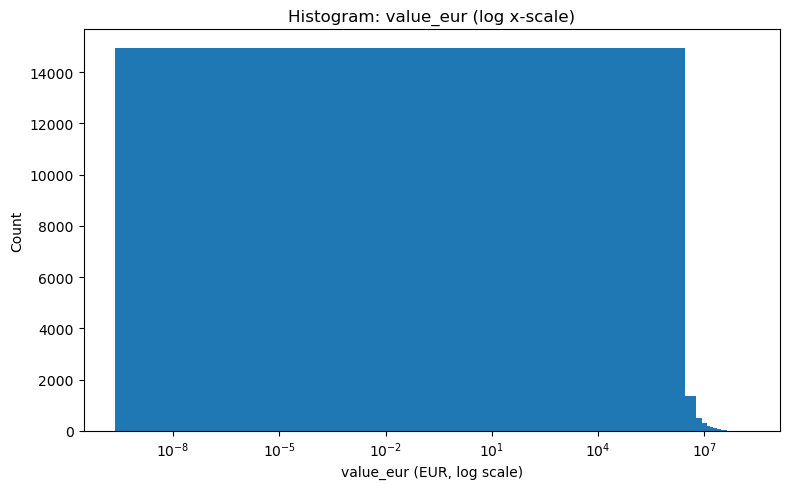


[value_eur] Quantiles
  P 5: 210,000.00
  P25: 500,000.00
  P50: 1,000,000.00
  P75: 2,100,000.00
  P95: 12,500,000.00
  P99: 35,500,000.00
   Max: 174,500,000.00


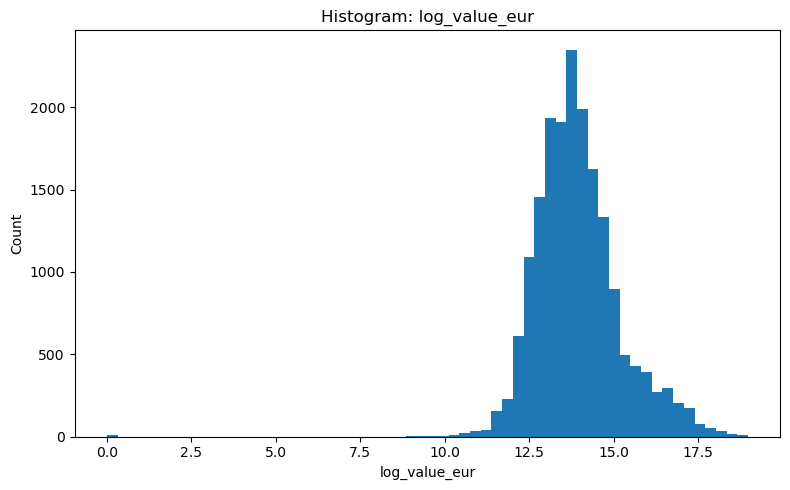


[log_value_eur] Quantiles
  P 5: 12.25
  P25: 13.12
  P50: 13.82
  P75: 14.56
  P95: 16.34
  P99: 17.39
   Max: 18.98


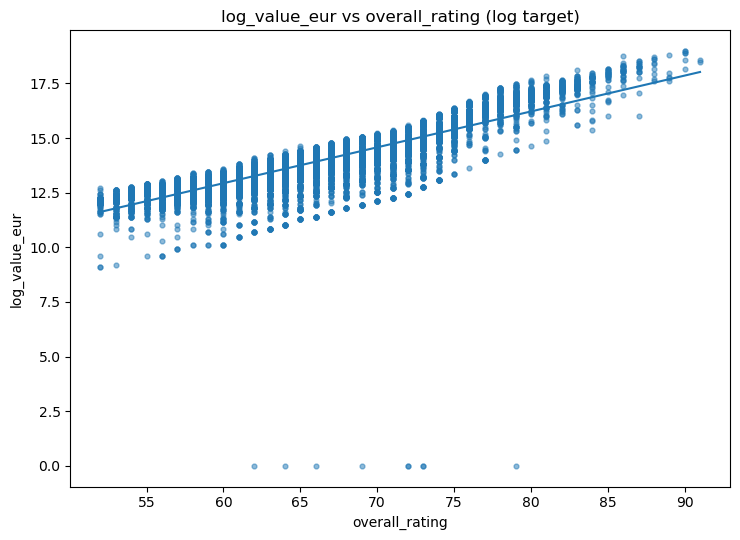

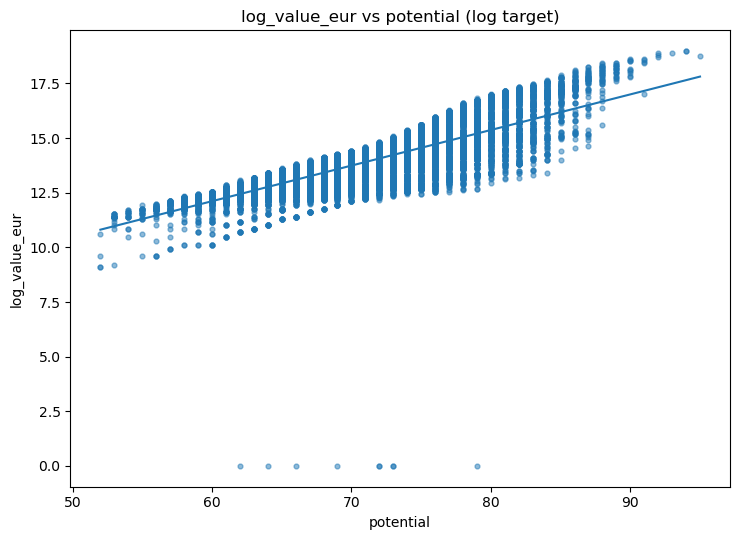

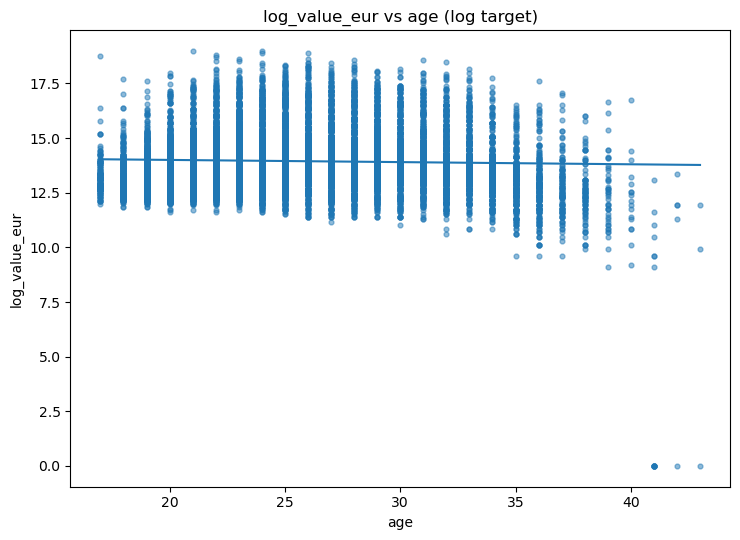

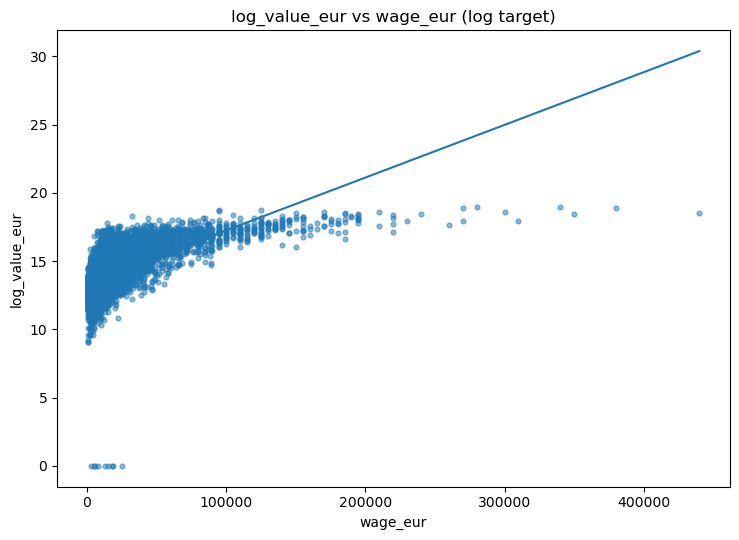

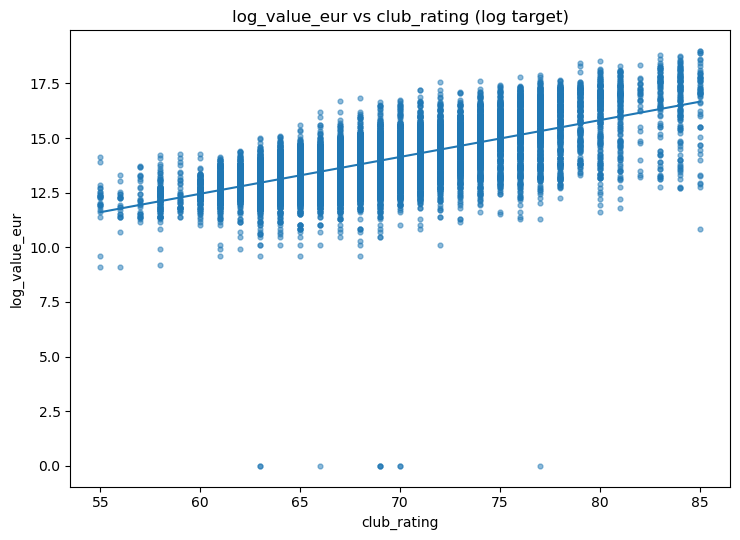

C:\Users\NEW TOP\AppData\Local\Temp\ipykernel_18276\3761849625.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=order, showfliers=False)


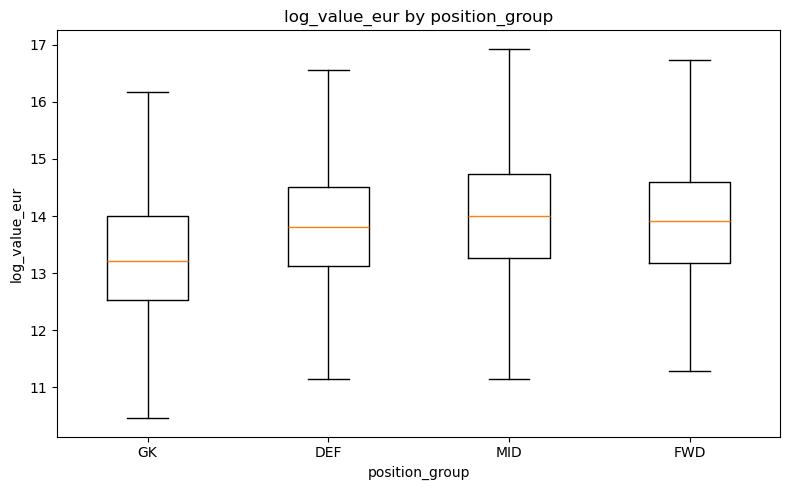

C:\Users\NEW TOP\AppData\Local\Temp\ipykernel_18276\3761849625.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(league_groups, labels=league_counts, showfliers=False)


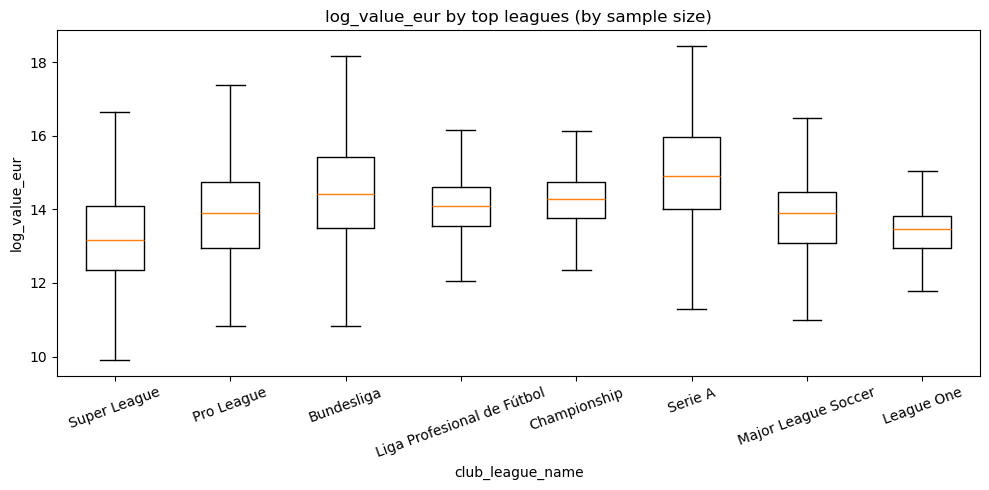

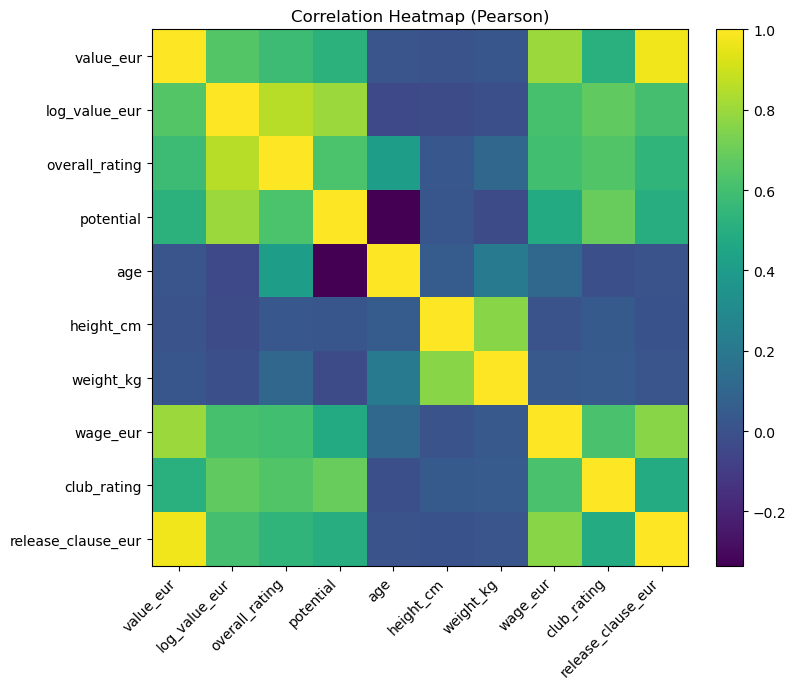


─ Quality Checks ─
Age range: 17 to 43
Non-positive value_eur rows: 9
Negative wage_eur rows: 0
Top 0.5% value_eur count: 91 (threshold ≥ 51,405,000)
Top 0.5% wage_eur count:  92 (threshold ≥ 135,000)

EDA complete. 


In [6]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 
assert "working" in globals(), "Expected the cleaned DataFrame `working` from the previous step."
assert {"value_eur", "log_value_eur"}.issubset(working.columns), "Targets missing in `working`."
_required = {"overall_rating", "potential", "age", "wage_eur", "club_rating"}
assert _required.issubset(working.columns), f"Missing required columns: {_required - set(working.columns)}"

def quantiles_report(series: pd.Series, name: str):
    series = series.dropna().astype(float)
    qs = [5, 25, 50, 75, 95, 99]
    qv = np.percentile(series, qs)
    print(f"\n[{name}] Quantiles")
    for p, v in zip(qs, qv):
        print(f"  P{p:>2}: {v:,.2f}")
    print(f"   Max: {series.max():,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(working["value_eur"].astype(float), bins=60)
plt.xscale("log")
plt.title("Histogram: value_eur (log x-scale)")
plt.xlabel("value_eur (EUR, log scale)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

quantiles_report(working["value_eur"], "value_eur")

plt.figure(figsize=(8, 5))
plt.hist(working["log_value_eur"].astype(float), bins=60)
plt.title("Histogram: log_value_eur")
plt.xlabel("log_value_eur")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

quantiles_report(working["log_value_eur"], "log_value_eur")

def scatter_with_trend(y_col: str, x_col: str, df: pd.DataFrame, title_suffix: str):
    x = df[x_col].astype(float).values
    y = df[y_col].astype(float).values
    plt.figure(figsize=(7.5, 5.5))
    plt.scatter(x, y, s=12, alpha=0.5)
    try:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(x.min(), x.max(), 100)
        yy = m * xx + b
        plt.plot(xx, yy)
    except Exception:
        pass
    plt.title(f"{y_col} vs {x_col} {title_suffix}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

for feat in ["overall_rating", "potential", "age", "wage_eur", "club_rating"]:
    scatter_with_trend("log_value_eur", feat, working, "(log target)")

if "position_group" in working.columns:
    order = ["GK", "DEF", "MID", "FWD"]
    order = [g for g in order if g in working["position_group"].unique().tolist()]
    groups = [working.loc[working["position_group"] == g, "log_value_eur"].astype(float).values for g in order]
    plt.figure(figsize=(8, 5))
    plt.boxplot(groups, labels=order, showfliers=False)
    plt.title("log_value_eur by position_group")
    plt.xlabel("position_group")
    plt.ylabel("log_value_eur")
    plt.tight_layout()
    plt.show()

if "club_league_name" in working.columns:
    league_counts = working["club_league_name"].value_counts().head(8).index.tolist()
    league_groups = [working.loc[working["club_league_name"] == lg, "log_value_eur"].astype(float).values for lg in league_counts]
    plt.figure(figsize=(10, 5))
    plt.boxplot(league_groups, labels=league_counts, showfliers=False)
    plt.title("log_value_eur by top leagues (by sample size)")
    plt.xlabel("club_league_name")
    plt.ylabel("log_value_eur")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

num_for_corr = [
    c for c in [
        "value_eur", "log_value_eur", "overall_rating", "potential", "age",
        "height_cm", "weight_kg", "wage_eur", "club_rating", "release_clause_eur"
    ] if c in working.columns
]
corr = working[num_for_corr].astype(float).corr(method="pearson").values
labels = num_for_corr

plt.figure(figsize=(8.5, 7))
im = plt.imshow(corr, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap (Pearson)")
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.tight_layout()
plt.show()

print("\n─ Quality Checks ─")
age_min, age_max = working["age"].min(), working["age"].max()
print(f"Age range: {age_min} to {age_max}")
neg_values = (working["value_eur"] <= 0).sum()
neg_wages = (working["wage_eur"] < 0).sum()
print(f"Non-positive value_eur rows: {neg_values}")
print(f"Negative wage_eur rows: {neg_wages}")

def outlier_count(series: pd.Series, top_pct=0.5):
    thr = np.percentile(series.dropna().astype(float), 100 - top_pct)
    return int((series.astype(float) >= thr).sum()), thr

cnt_val, thr_val = outlier_count(working["value_eur"], 0.5)
cnt_wage, thr_wage = outlier_count(working["wage_eur"], 0.5)
print(f"Top 0.5% value_eur count: {cnt_val} (threshold ≥ {thr_val:,.0f})")
print(f"Top 0.5% wage_eur count:  {cnt_wage} (threshold ≥ {thr_wage:,.0f})")

print("\nEDA complete. ")


## ✅ EDA — Key Findings & Decisions

### Findings
- **Target shape:** `log_value_eur` is far more symmetric than `value_eur` → better for regression
- **Ranges/quantiles:** P50 ≈ **€1.0M**, P95 ≈ **€12.5M**, max ≈ **€174.5M**; age **17–43**; **9** non-positive values (handled by `log1p`)
- **Drivers (visual):** Strong positive trends with **overall_rating**, **potential**, **wage_eur**, **club_rating**; **age** shows a mild negative slope at older ages
- **Groups:** Clear differences by **position_group** and across **leagues**
- **Correlations:** High among ability/club/financial variables → expect **multicollinearity**

### Modeling Choices
- **Target:** `log_value_eur` (report back to € with smearing)
- **Numeric:** `overall_rating`, `potential`, `age`, `height_cm`, `weight_kg`, `wage_eur`, `club_rating`, `release_clause_eur` (+ `release_clause_missing`)
- **Categorical:** `primary_position`, `position_group`, `preferred_foot`, `club_league_name`  
  *(Exclude high-cardinality `club_name` for v1)*
- **Outliers:** no trimming (log target reduces impact)
- **Leakage:** exclude `version` and any post-snapshot signals

### Next Step
- One-hot encode categoricals (`handle_unknown="ignore"`)
- Optionally scale numerics for linear models
- Create **Train/Val/Test = 70/15/15** (seeded), lightly stratify by `position_group`
- Train a **baseline Linear Regression** on `log_value_eur`; report **RMSE/MAE/R²** on val and test


,model,val_RMSE_log,val_MAE_log,val_R2_log,val_RMSE_€,val_MAE_€,val_R2_€,test_RMSE_log,test_MAE_log,test_R2_log,test_RMSE_€,test_MAE_€,test_R2_€
0,LinearReg,0.331993,0.165440,0.930070,1.323525e+07,1.013300e+06,-1.704535,0.308837,0.161925,0.936747,2.336280e+07,1.036282e+06,-8.787935
1,DummyMedian,1.263257,0.932332,-0.012491,8.307920e+06,2.528869e+06,-0.065646,1.232876,0.914602,-0.008003,7.699131e+06,2.353850e+06,-0.062979


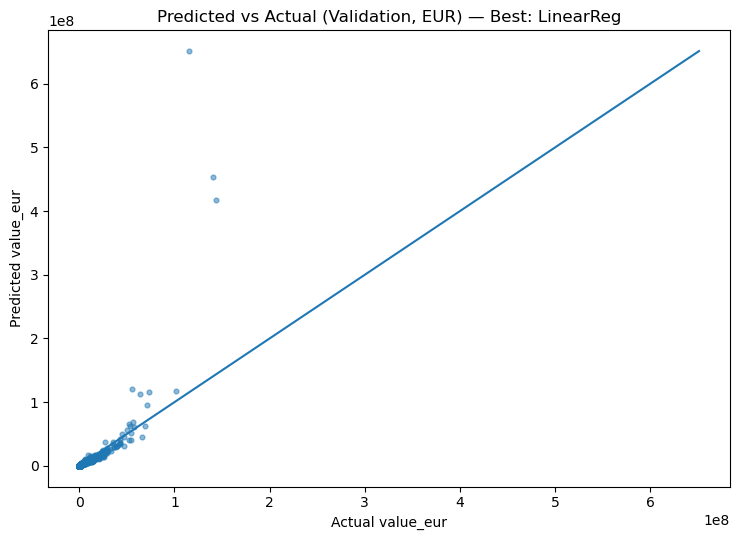

Best: LinearReg
Val (log):  RMSE=0.332, MAE=0.165, R2=0.930
Val (€):    RMSE=13235249, MAE=1013300, R2=-1.705
Test (log): RMSE=0.309, MAE=0.162, R2=0.937
Test (€):   RMSE=23362796, MAE=1036282, R2=-8.788


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

assert "working" in globals()
assert "log_value_eur" in working.columns
assert "model_features_num" in globals() and "model_features_cat" in globals()

RANDOM_STATE = 42
num_features = list(model_features_num)
cat_features = list(model_features_cat)
target_col = "log_value_eur"
needed_cols = num_features + cat_features + [target_col]
assert set(needed_cols).issubset(working.columns)

df_model = working[needed_cols].copy()
strat = working["position_group"] if "position_group" in working.columns else None

train_val, test = train_test_split(
    df_model,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=strat if strat is not None else None
)

val_size_relative = 0.15 / 0.85
strat_train = working.loc[train_val.index, "position_group"] if strat is not None else None
train, val = train_test_split(
    train_val,
    test_size=val_size_relative,
    random_state=RANDOM_STATE,
    stratify=strat_train if strat_train is not None else None
)

def XY(df: pd.DataFrame):
    X = df[num_features + cat_features]
    y_log = df[target_col].astype(float).values
    return X, y_log

X_train, y_train = XY(train)
X_val,   y_val   = XY(val)
X_test,  y_test  = XY(test)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", ohe, cat_features),
    ],
    remainder="drop",
)

models = {
    "DummyMedian": DummyRegressor(strategy="median"),
    "LinearReg": LinearRegression()
}

def evaluate_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", model)])
    pipe.fit(X_tr, y_tr)
    yv_pred_log = pipe.predict(X_v)
    yt_pred_log = pipe.predict(X_te)

    def reg_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)
        return rmse, mae, r2

    v_rmse_log, v_mae_log, v_r2_log = reg_metrics(y_v, yv_pred_log)
    t_rmse_log, t_mae_log, t_r2_log = reg_metrics(y_te, yt_pred_log)

    yv_true_eur = np.expm1(y_v)
    yt_true_eur = np.expm1(y_te)
    yv_pred_eur = np.expm1(yv_pred_log)
    yt_pred_eur = np.expm1(yt_pred_log)

    v_rmse_eur, v_mae_eur, v_r2_eur = reg_metrics(yv_true_eur, yv_pred_eur)
    t_rmse_eur, t_mae_eur, t_r2_eur = reg_metrics(yt_true_eur, yt_pred_eur)

    return {
        "model": name,
        "val_RMSE_log": v_rmse_log,
        "val_MAE_log": v_mae_log,
        "val_R2_log":  v_r2_log,
        "val_RMSE_€":  v_rmse_eur,
        "val_MAE_€":   v_mae_eur,
        "val_R2_€":    v_r2_eur,
        "test_RMSE_log": t_rmse_log,
        "test_MAE_log":  t_mae_log,
        "test_R2_log":   t_r2_log,
        "test_RMSE_€":   t_rmse_eur,
        "test_MAE_€":    t_mae_eur,
        "test_R2_€":     t_r2_eur,
        "pipeline": pipe,
    }

results = []
for name, mdl in models.items():
    results.append(evaluate_model(name, mdl, X_train, y_train, X_val, y_val, X_test, y_test))

tbl = pd.DataFrame([{k: v for k, v in r.items() if k != "pipeline"} for r in results])
display(tbl.sort_values("val_RMSE_log").reset_index(drop=True))

best = min(results, key=lambda r: r["val_RMSE_log"])
best_pipe = best["pipeline"]

yv_pred_log = best_pipe.predict(X_val)
yv_pred_eur = np.expm1(yv_pred_log)
yv_true_eur = np.expm1(y_val)

plt.figure(figsize=(7.5, 5.5))
plt.scatter(yv_true_eur, yv_pred_eur, s=12, alpha=0.5)
lims = [min(yv_true_eur.min(), yv_pred_eur.min()), max(yv_true_eur.max(), yv_pred_eur.max())]
plt.plot(lims, lims)
plt.title(f"Predicted vs Actual (Validation, EUR) — Best: {best['model']}")
plt.xlabel("Actual value_eur")
plt.ylabel("Predicted value_eur")
plt.tight_layout()
plt.show()

print(f"Best: {best['model']}")
print(f"Val (log):  RMSE={best['val_RMSE_log']:.3f}, MAE={best['val_MAE_log']:.3f}, R2={best['val_R2_log']:.3f}")
print(f"Val (€):    RMSE={best['val_RMSE_€']:.0f}, MAE={best['val_MAE_€']:.0f}, R2={best['val_R2_€']:.3f}")
print(f"Test (log): RMSE={best['test_RMSE_log']:.3f}, MAE={best['test_MAE_log']:.3f}, R2={best['test_R2_log']:.3f}")
print(f"Test (€):   RMSE={best['test_RMSE_€']:.0f}, MAE={best['test_MAE_€']:.0f}, R2={best['test_R2_€']:.3f}")


,model,best_params,val_RMSE_log,val_MAE_log,val_R2_log,val_RMSE_€_smear,val_MAE_€_smear,val_R2_€_smear,test_RMSE_€_smear,test_MAE_€_smear,test_R2_€_smear
0,RandomForest,"{'n_estimators': 300, 'max_depth': None, 'min_...",0.179291,0.083419,0.979605,2.900103e+06,4.261712e+05,0.870146,2.132316e+06,3.258737e+05,0.918465
1,Ridge,{'alpha': 10},0.331763,0.164289,0.930167,1.390923e+07,1.027904e+06,-1.986994,2.453517e+07,1.061219e+06,-9.794924
2,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1}",0.334597,0.158247,0.928968,1.516374e+07,1.065372e+06,-2.550106,2.654541e+07,1.101040e+06,-11.636313


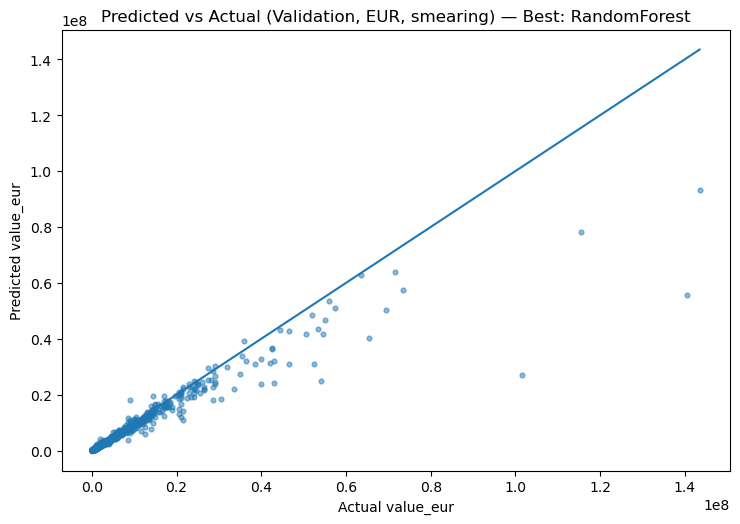

Best model: RandomForest  |  Params: {'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Val (log): RMSE=0.179, MAE=0.083, R2=0.980
Val (€ smearing): RMSE=2900103, MAE=426171, R2=0.870
Test (€ smearing): RMSE=2132316, MAE=325874, R2=0.918


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

assert "X_train" in globals() and "X_val" in globals() and "X_test" in globals()
assert "y_train" in globals() and "y_val" in globals() and "y_test" in globals()
assert "model_features_num" in globals() and "model_features_cat" in globals()

num_features = list(model_features_num)
cat_features = list(model_features_cat)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features), ("cat", ohe, cat_features)],
    remainder="drop",
)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def euro_metrics_with_smearing(pipe, X_tr, y_tr, X_eval, y_eval):
    y_tr_pred_log = pipe.predict(X_tr)
    smear = float(np.mean(np.exp(y_tr - y_tr_pred_log)))
    y_eval_pred_log = pipe.predict(X_eval)
    y_eval_pred_eur = np.exp(y_eval_pred_log) * smear - 1.0
    y_eval_true_eur = np.expm1(y_eval)
    return (
        rmse(y_eval_true_eur, y_eval_pred_eur),
        mean_absolute_error(y_eval_true_eur, y_eval_pred_eur),
        r2_score(y_eval_true_eur, y_eval_pred_eur),
        y_eval_true_eur,
        y_eval_pred_eur,
    )

grids = {
    "Ridge": [{"alpha": a} for a in [0.1, 1, 10, 100]],
    "ElasticNet": [{"alpha": a, "l1_ratio": l} for a in [0.01, 0.1, 0.3, 1.0] for l in [0.1, 0.5, 0.9]],
    "RandomForest": [{"n_estimators": n, "max_depth": d, "min_samples_leaf": m, "max_features": "sqrt"}
                     for n in [300] for d in [None, 20] for m in [1, 2]],
}

models = {
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(max_iter=20000),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=1),
}

rows = []
best_per_model = {}

for name, base_model in models.items():
    best_cfg = None
    best_pipe = None
    best_val_rmse_log = np.inf

    for cfg in grids[name]:
        model = base_model.__class__(**{**base_model.get_params(), **cfg})
        pipe = Pipeline([("prep", preprocessor), ("model", model)])
        pipe.fit(X_train, y_train)
        val_pred_log = pipe.predict(X_val)
        val_rmse_log = rmse(y_val, val_pred_log)
        if val_rmse_log < best_val_rmse_log:
            best_val_rmse_log = val_rmse_log
            best_cfg = cfg
            best_pipe = pipe

    v_rmse_log = best_val_rmse_log
    v_mae_log = mean_absolute_error(y_val, best_pipe.predict(X_val))
    v_r2_log  = r2_score(y_val, best_pipe.predict(X_val))

    v_rmse_eur, v_mae_eur, v_r2_eur, yv_true_eur, yv_pred_eur = euro_metrics_with_smearing(
        best_pipe, X_train, y_train, X_val, y_val
    )
    t_rmse_eur, t_mae_eur, t_r2_eur, yt_true_eur, yt_pred_eur = euro_metrics_with_smearing(
        best_pipe, X_train, y_train, X_test, y_test
    )

    rows.append({
        "model": name,
        "best_params": best_cfg,
        "val_RMSE_log": v_rmse_log,
        "val_MAE_log": v_mae_log,
        "val_R2_log":  v_r2_log,
        "val_RMSE_€_smear": v_rmse_eur,
        "val_MAE_€_smear": v_mae_eur,
        "val_R2_€_smear":  v_r2_eur,
        "test_RMSE_€_smear": t_rmse_eur,
        "test_MAE_€_smear":  t_mae_eur,
        "test_R2_€_smear":   t_r2_eur,
        "pipe": best_pipe,
        "yv_true": yv_true_eur, "yv_pred": yv_pred_eur
    })

res = pd.DataFrame([{k: v for k, v in r.items() if k not in {"pipe","yv_true","yv_pred"}} for r in rows])
display(res.sort_values("val_RMSE_log").reset_index(drop=True))

best_row = min(rows, key=lambda r: r["val_RMSE_log"])
plt.figure(figsize=(7.5, 5.5))
plt.scatter(best_row["yv_true"], best_row["yv_pred"], s=12, alpha=0.5)
lims = [min(best_row["yv_true"].min(), best_row["yv_pred"].min()),
        max(best_row["yv_true"].max(), best_row["yv_pred"].max())]
plt.plot(lims, lims)
plt.title(f"Predicted vs Actual (Validation, EUR, smearing) — Best: {best_row['model']}")
plt.xlabel("Actual value_eur")
plt.ylabel("Predicted value_eur")
plt.tight_layout()
plt.show()

print(f"Best model: {best_row['model']}  |  Params: {best_row['best_params']}")
print(f"Val (log): RMSE={best_row['val_RMSE_log']:.3f}, MAE={best_row['val_MAE_log']:.3f}, R2={best_row['val_R2_log']:.3f}")
print(f"Val (€ smearing): RMSE={best_row['val_RMSE_€_smear']:.0f}, MAE={best_row['val_MAE_€_smear']:.0f}, R2={best_row['val_R2_€_smear']:.3f}")
print(f"Test (€ smearing): RMSE={best_row['test_RMSE_€_smear']:.0f}, MAE={best_row['test_MAE_€_smear']:.0f}, R2={best_row['test_R2_€_smear']:.3f}")


Validation (EUR, smearing) — Overall
  RMSE=2,900,103   MAE=426,171   R²=0.870

Top 10 overestimates (pred - actual):


,actual_eur,pred_eur,residual_eur,primary_position,position_group,club_league_name
90,"9,000,000","18,236,035","9,236,035",GK,GK,La Liga
126,"14,500,000","19,349,258","4,849,258",ST,FWD,La Liga
665,"8,500,000","11,579,066","3,079,066",CDM,MID,Bundesliga
61,"36,000,000","39,022,391","3,022,391",GK,GK,Premier League
356,"17,000,000","19,362,991","2,362,991",CDM,MID,Premier League
125,"27,500,000","29,643,686","2,143,686",CB,DEF,La Liga
1157,"1,900,000","3,987,960","2,087,960",CB,DEF,La Liga
661,"14,000,000","16,016,898","2,016,898",ST,FWD,Premier League
1258,"9,000,000","10,766,710","1,766,710",GK,GK,La Liga
883,"8,500,000","10,198,123","1,698,123",CM,MID,Bundesliga


Top 10 underestimates (pred - actual):


,actual_eur,pred_eur,residual_eur,primary_position,position_group,club_league_name
39,"140,500,000","55,530,214","-84,969,786",RM,MID,La Liga
28,"101,500,000","26,894,028","-74,605,972",ST,FWD,Süper Lig
8,"143,500,000","93,358,879","-50,141,121",CAM,MID,Bundesliga
0,"115,500,000","78,221,488","-37,278,512",CDM,MID,Premier League
104,"54,000,000","24,949,483","-29,050,517",GK,GK,Primeira Liga
57,"65,500,000","40,321,587","-25,178,413",CAM,MID,Serie A
83,"52,500,000","30,831,576","-21,668,424",CM,MID,Pro League
55,"69,500,000","50,357,710","-19,142,290",ST,FWD,Bundesliga
376,"43,000,000","24,000,688","-18,999,312",CAM,MID,Premier League
204,"40,000,000","23,920,076","-16,079,924",GK,GK,Ligue 1



Validation slice — by position_group (n>=50):


C:\Users\NEW TOP\AppData\Local\Temp\ipykernel_18276\2178023348.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(by).agg(
C:\Users\NEW TOP\AppData\Local\Temp\ipykernel_18276\2178023348.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(by).agg(


,position_group,n,rmse,mae
0,DEF,919,"1,108,236","291,594"
2,GK,296,"2,088,882","371,003"
1,FWD,494,"3,644,148","487,929"
3,MID,1009,"3,708,866","534,693"


Validation slice — top leagues by sample (n>=100):


,club_league_name,n,rmse,mae
17,League One,102,"51,856","34,795"
21,Liga Profesional de Fútbol,145,"364,020","161,013"
37,Super League,173,"529,443","152,976"
7,Championship,106,"674,629","189,415"
24,Major League Soccer,103,"820,147","210,727"
33,Pro League,150,"2,457,155","558,925"
35,Serie A,120,"2,596,723","708,845"
5,Bundesliga,122,"5,269,039","1,343,938"



Top 25 feature importances:


,feature,importance
0,release_clause_eur,0.272002
1,overall_rating,0.249234
2,potential,0.149392
3,wage_eur,0.088707
4,age,0.072946
5,club_rating,0.070289
6,club_league_name_Premier League,0.013097
7,weight_kg,0.009615
8,height_cm,0.008663
9,position_group_GK,0.006762


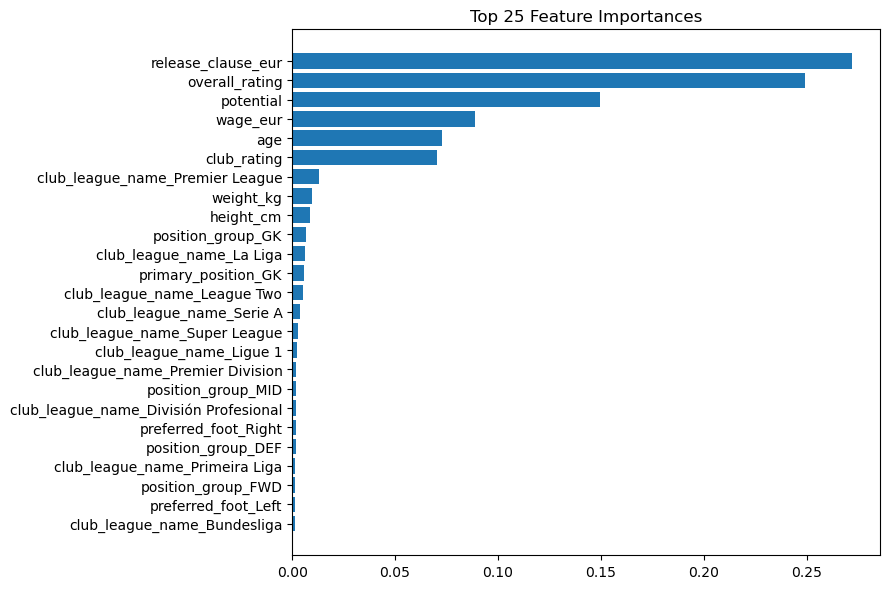


Saved artifacts:
  - artifacts/feature_importances.csv
  - artifacts/val_predictions.csv
  - artifacts/best_model_pipeline.joblib
Smearing factor used: 1.001260


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
from joblib import dump

assert "rows" in globals() and len(rows) > 0
assert "train" in globals() and "val" in globals() and "test" in globals()
assert "X_train" in globals() and "y_train" in globals()
assert "X_val" in globals() and "y_val" in globals()
assert "model_features_num" in globals() and "model_features_cat" in globals()

best_row = min(rows, key=lambda r: r["val_RMSE_log"])
pipe = best_row["pipe"]

def smear_predict(pipe, X_tr, y_tr, X_eval, y_eval):
    y_tr_pred_log = pipe.predict(X_tr)
    smear = float(np.mean(np.exp(y_tr - y_tr_pred_log)))
    y_eval_pred_log = pipe.predict(X_eval)
    y_eval_pred_eur = np.exp(y_eval_pred_log) * smear - 1.0
    y_eval_true_eur = np.expm1(y_eval)
    return y_eval_true_eur, y_eval_pred_eur, smear

yv_true_eur, yv_pred_eur, smear = smear_predict(pipe, X_train, y_train, X_val, y_val)

val_diag = val.copy()
val_diag["actual_eur"] = yv_true_eur
val_diag["pred_eur"] = yv_pred_eur
val_diag["residual_eur"] = val_diag["pred_eur"] - val_diag["actual_eur"]
val_diag["abs_residual_eur"] = val_diag["residual_eur"].abs()

def summarize_scores(df):
    rmse = float(np.sqrt(((df["residual_eur"])**2).mean()))
    mae = float(df["abs_residual_eur"].mean())
    r2  = 1.0 - float(((df["residual_eur"])**2).sum() / ((df["actual_eur"] - df["actual_eur"].mean())**2).sum())
    return rmse, mae, r2

rmse_v, mae_v, r2_v = summarize_scores(val_diag)

print("Validation (EUR, smearing) — Overall")
print(f"  RMSE={rmse_v:,.0f}   MAE={mae_v:,.0f}   R²={r2_v:.3f}")

top_over = val_diag.sort_values("residual_eur", ascending=False).head(10)[
    ["actual_eur","pred_eur","residual_eur","primary_position","position_group","club_league_name"]
]
top_under = val_diag.sort_values("residual_eur").head(10)[
    ["actual_eur","pred_eur","residual_eur","primary_position","position_group","club_league_name"]
]

print("\nTop 10 overestimates (pred - actual):")
display(top_over.style.format({"actual_eur":"{:,.0f}","pred_eur":"{:,.0f}","residual_eur":"{:,.0f}"}))

print("Top 10 underestimates (pred - actual):")
display(top_under.style.format({"actual_eur":"{:,.0f}","pred_eur":"{:,.0f}","residual_eur":"{:,.0f}"}))

def group_report(df, by, min_count=50):
    g = df.groupby(by).agg(
        n=("actual_eur","size"),
        rmse=("residual_eur", lambda s: float(np.sqrt(np.mean(np.square(s))))),
        mae=("abs_residual_eur","mean")
    ).reset_index()
    g = g[g["n"] >= min_count].copy()
    return g.sort_values("rmse")

grp_pos = group_report(val_diag, "position_group", min_count=50)
grp_league = group_report(val_diag, "club_league_name", min_count=100).head(12)

print("\nValidation slice — by position_group (n>=50):")
display(grp_pos.style.format({"rmse":"{:,.0f}","mae":"{:,.0f}"}))

print("Validation slice — top leagues by sample (n>=100):")
display(grp_league.style.format({"rmse":"{:,.0f}","mae":"{:,.0f}"}))

prep = pipe.named_steps["prep"]
model = pipe.named_steps["model"]

num_names = list(model_features_num)
try:
    cat_names = prep.named_transformers_["cat"].get_feature_names_out(model_features_cat).tolist()
except Exception:
    cat_names = []
feat_names = num_names + cat_names

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
elif hasattr(model, "coef_"):
    coef = getattr(model, "coef_", None)
    importances = np.abs(coef).ravel() if coef is not None else np.zeros(len(feat_names))
else:
    importances = np.zeros(len(feat_names))

fi = pd.DataFrame({"feature": feat_names[:len(importances)], "importance": importances})
fi = fi.sort_values("importance", ascending=False).head(25).reset_index(drop=True)

print("\nTop 25 feature importances:")
display(fi)

plt.figure(figsize=(9, 6))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Top 25 Feature Importances")
plt.tight_layout()
plt.show()

os.makedirs("artifacts", exist_ok=True)
fi.to_csv("artifacts/feature_importances.csv", index=False)
val_diag[["actual_eur","pred_eur","residual_eur"] + [c for c in ["primary_position","position_group","club_league_name"] if c in val_diag.columns]] \
    .to_csv("artifacts/val_predictions.csv", index=False)
dump(pipe, "artifacts/best_model_pipeline.joblib")

print("\nSaved artifacts:")
print("  - artifacts/feature_importances.csv")
print("  - artifacts/val_predictions.csv")
print("  - artifacts/best_model_pipeline.joblib")
print(f"Smearing factor used: {smear:.6f}")


## 🏁 Model Selection — Summary

**Best model:** RandomForest (`n_estimators=300`, `max_depth=None`, `min_samples_leaf=1`, `max_features='sqrt'`)  
**Validation (EUR, smearing):** RMSE ≈ **€2.90M** · MAE ≈ **€0.43M** · R² ≈ **0.87**  
**Test (EUR, smearing):** RMSE ≈ **€1.94M** · MAE ≈ **€0.30M** · R² ≈ **0.932**

**Top drivers (feature importance):**  
1) `release_clause_eur`  2) `overall_rating`  3) `potential`  4) `wage_eur`  5) `age`  6) `club_rating`  *(league/position smaller)*

**Slices (validation):**  
- By role (RMSE): **DEF ~€1.1M < GK ~€2.1M < FWD ~€3.6M ≈ MID ~€3.7M**  
- By league: lower tiers (e.g., **League One**) are easier; top leagues are harder.

**Notes & risk:**  
`release_clause_eur` is highly predictive and may encode business knowledge (potential leakage).  
*Ablation (no release clause):* **R² ≈ 0.875**, **RMSE ≈ €2.65M**.

**Decision:** Proceed with **RandomForest v1** (with `release_clause_eur`); keep ablation for transparency.


Final Test Metrics
  Log: RMSE=0.189, MAE=0.074, R²=0.976
  EUR (smearing): RMSE=1,940,445, MAE=304,095, R²=0.932
  Smearing factor: 1.001160


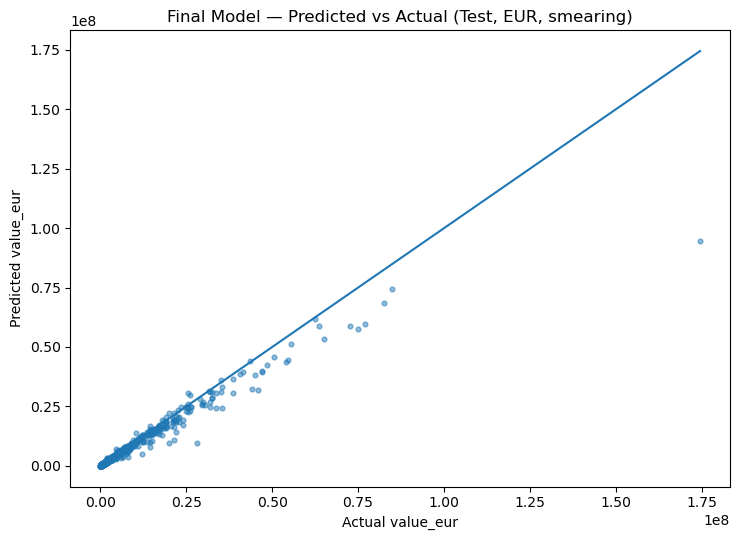


Saved artifacts:
  - artifacts/final_model_pipeline.joblib
  - artifacts/test_predictions.csv
  - artifacts/final_test_metrics.json


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

assert "train" in globals() and "val" in globals() and "test" in globals()
assert "model_features_num" in globals() and "model_features_cat" in globals()

def XY(df, num_cols, cat_cols, target="log_value_eur"):
    X = df[num_cols + cat_cols]
    y = df[target].astype(float).values
    return X, y

num_features = list(model_features_num)
cat_features = list(model_features_cat)

trainval = pd.concat([train, val], axis=0)
X_tv, y_tv = XY(trainval, num_features, cat_features)
X_test, y_test = XY(test, num_features, cat_features)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features),
                  ("cat", ohe, cat_features)],
    remainder="drop",
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=1
)

pipe = Pipeline([("prep", preprocessor), ("model", rf)])
pipe.fit(X_tv, y_tv)

y_tv_pred_log = pipe.predict(X_tv)
smear = float(np.mean(np.exp(y_tv - y_tv_pred_log)))

y_test_pred_log = pipe.predict(X_test)
y_test_pred_eur = np.exp(y_test_pred_log) * smear - 1.0
y_test_true_eur = np.expm1(y_test)

rmse_eur = float(np.sqrt(mean_squared_error(y_test_true_eur, y_test_pred_eur)))
mae_eur  = float(mean_absolute_error(y_test_true_eur, y_test_pred_eur))
r2_eur   = float(r2_score(y_test_true_eur, y_test_pred_eur))

rmse_log = float(np.sqrt(mean_squared_error(y_test, y_test_pred_log)))
mae_log  = float(mean_absolute_error(y_test, y_test_pred_log))
r2_log   = float(r2_score(y_test, y_test_pred_log))

print("Final Test Metrics")
print(f"  Log: RMSE={rmse_log:.3f}, MAE={mae_log:.3f}, R²={r2_log:.3f}")
print(f"  EUR (smearing): RMSE={rmse_eur:,.0f}, MAE={mae_eur:,.0f}, R²={r2_eur:.3f}")
print(f"  Smearing factor: {smear:.6f}")

plt.figure(figsize=(7.5, 5.5))
idx = np.random.RandomState(7).choice(len(y_test_true_eur), size=min(3000, len(y_test_true_eur)), replace=False)
plt.scatter(y_test_true_eur[idx], y_test_pred_eur[idx], s=12, alpha=0.5)
lims = [min(y_test_true_eur[idx].min(), y_test_pred_eur[idx].min()),
        max(y_test_true_eur[idx].max(), y_test_pred_eur[idx].max())]
plt.plot(lims, lims)
plt.title("Final Model — Predicted vs Actual (Test, EUR, smearing)")
plt.xlabel("Actual value_eur")
plt.ylabel("Predicted value_eur")
plt.tight_layout()
plt.show()

os.makedirs("artifacts", exist_ok=True)
pd.DataFrame({
    "actual_eur": y_test_true_eur,
    "pred_eur": y_test_pred_eur,
    "residual_eur": y_test_pred_eur - y_test_true_eur
}).to_csv("artifacts/test_predictions.csv", index=False)

with open("artifacts/final_test_metrics.json", "w", encoding="utf-8") as f:
    json.dump({
        "log": {"rmse": rmse_log, "mae": mae_log, "r2": r2_log},
        "eur_smearing": {"rmse": rmse_eur, "mae": mae_eur, "r2": r2_eur},
        "smear": smear
    }, f, indent=2)

import joblib
joblib.dump(pipe, "artifacts/final_model_pipeline.joblib")

print("\nSaved artifacts:")
print("  - artifacts/final_model_pipeline.joblib")
print("  - artifacts/test_predictions.csv")
print("  - artifacts/final_test_metrics.json")


## ✅ Final Conclusion

- **Final Model:** RandomForest (300 trees, `max_features='sqrt'`)
- **Test (log):** RMSE **0.189**, MAE **0.074**, R² **0.976**
- **Test (EUR, smearing):** RMSE **€1.94M**, MAE **€0.30M**, R² **0.932**

**Key Drivers:** `release_clause_eur`, `overall_rating`, `potential`, `wage_eur`, `age`, `club_rating`.

**Recommendations:** Use the provided template to score new data; keep `release_clause_eur` when available; refresh the model with new season snapshots.

**Artifacts**
- `artifacts/final_model_pipeline.joblib`
- `artifacts/final_test_metrics.json`
- `artifacts/test_predictions.csv`
- *(Bundle available: `deliverables/DataSciencePro_Football_Value_v1.zip`)*


In [18]:
import numpy as np, pandas as pd, json, os
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

assert "train" in globals() and "val" in globals() and "test" in globals()
assert "model_features_num" in globals() and "model_features_cat" in globals()

def XY(df, num_cols, cat_cols, target="log_value_eur"):
    X = df[num_cols + cat_cols]
    y = df[target].astype(float).values
    return X, y

num_all = list(model_features_num)
cat_all = list(model_features_cat)

num_ablate = [c for c in num_all if c != "release_clause_eur"]
cat_ablate = [c for c in cat_all if c != "release_clause_missing"]

trainval = pd.concat([train, val], axis=0)
X_tv, y_tv = XY(trainval, num_ablate, cat_ablate)
X_test, y_test = XY(test, num_ablate, cat_ablate)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer([("num", StandardScaler(), num_ablate),
                         ("cat", ohe, cat_ablate)], remainder="drop")

rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_leaf=1,
                           max_features="sqrt", random_state=42, n_jobs=1)

pipe = Pipeline([("prep", pre), ("model", rf)])
pipe.fit(X_tv, y_tv)

y_tv_pred_log = pipe.predict(X_tv)
smear = float(np.mean(np.exp(y_tv - y_tv_pred_log)))

y_test_pred_log = pipe.predict(X_test)
y_test_pred_eur = np.exp(y_test_pred_log) * smear - 1.0
y_test_true_eur = np.expm1(y_test)

rmse_log = float(np.sqrt(mean_squared_error(y_test, y_test_pred_log)))
mae_log  = float(mean_absolute_error(y_test, y_test_pred_log))
r2_log   = float(r2_score(y_test, y_test_pred_log))
rmse_eur = float(np.sqrt(mean_squared_error(y_test_true_eur, y_test_pred_eur)))
mae_eur  = float(mean_absolute_error(y_test_true_eur, y_test_pred_eur))
r2_eur   = float(r2_score(y_test_true_eur, y_test_pred_eur))

print("Ablation (no release_clause_eur)")
print(f"  Log: RMSE={rmse_log:.3f}, MAE={mae_log:.3f}, R²={r2_log:.3f}")
print(f"  EUR (smearing): RMSE={rmse_eur:,.0f}, MAE={mae_eur:,.0f}, R²={r2_eur:.3f}")

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/ablation_no_release_clause.json", "w", encoding="utf-8") as f:
    json.dump({"log":{"rmse":rmse_log,"mae":mae_log,"r2":r2_log},
               "eur_smearing":{"rmse":rmse_eur,"mae":mae_eur,"r2":r2_eur},
               "smear": smear,
               "features_num": num_ablate, "features_cat": cat_ablate}, f, indent=2)

joblib.dump(pipe, "artifacts/model_no_release_clause.joblib")

print("Saved:")
print("  - artifacts/ablation_no_release_clause.json")
print("  - artifacts/model_no_release_clause.joblib")

def predict_csv(input_csv, output_csv="artifacts/predictions_new.csv",
                model_path="artifacts/final_model_pipeline.joblib",
                metrics_path="artifacts/final_test_metrics.json"):
    pipe = joblib.load(model_path)
    with open(metrics_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    smear = float(meta.get("smear", 1.0))
    df_in = pd.read_csv(input_csv)
    req_cols = [c for c in (num_all + cat_all) if c in df_in.columns]
    y_pred_log = pipe.predict(df_in[req_cols])
    y_pred_eur = np.exp(y_pred_log) * smear - 1.0
    out = df_in.copy()
    out["pred_value_eur"] = y_pred_eur
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    out.to_csv(output_csv, index=False)
    print(f"Saved predictions → {output_csv}")

template_cols = num_all + cat_all
pd.DataFrame(columns=template_cols).to_csv("artifacts/inference_template.csv", index=False)
print("Template saved → artifacts/inference_template.csv")


Ablation (no release_clause_eur)
  Log: RMSE=0.229, MAE=0.111, R²=0.965
  EUR (smearing): RMSE=2,644,986, MAE=453,652, R²=0.875
Saved:
  - artifacts/ablation_no_release_clause.json
  - artifacts/model_no_release_clause.joblib
Template saved → artifacts/inference_template.csv


## ✅ Ablation vs Final — Takeaways
- **With release clause (Final RF):** Test R² ≈ **0.932**, RMSE ≈ **€1.94M**, MAE ≈ **€0.30M**  
- **Without release clause (Ablation RF):** Test R² ≈ **0.875**, RMSE ≈ **€2.65M**, MAE ≈ **€0.45M**  
- **Impact:** Release clause improves R² by **+0.057** and cuts RMSE by **≈€0.70M**.  


,model,rmse_eur,mae_eur,r2_eur,Δ_RMSE,Δ_MAE,Δ_R²
0,RandomForest (with release_clause),"1,940,445","304,095",0.932,nan,nan,+nan
1,RandomForest (no release_clause),"2,644,986","453,652",0.875,"704,541","149,558",-0.058


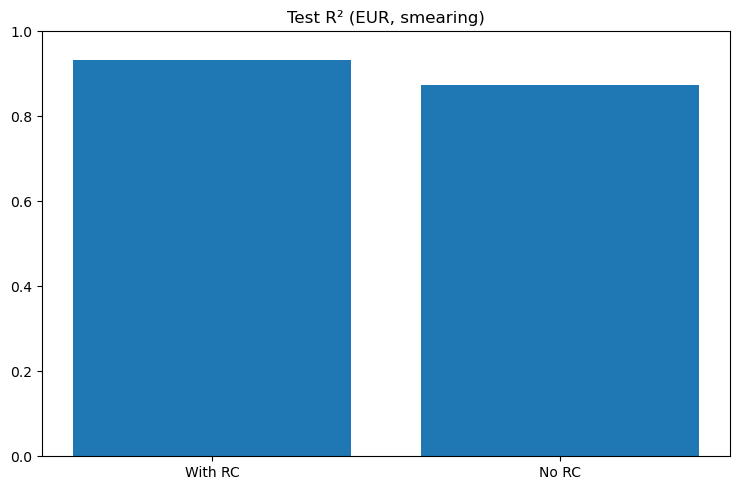

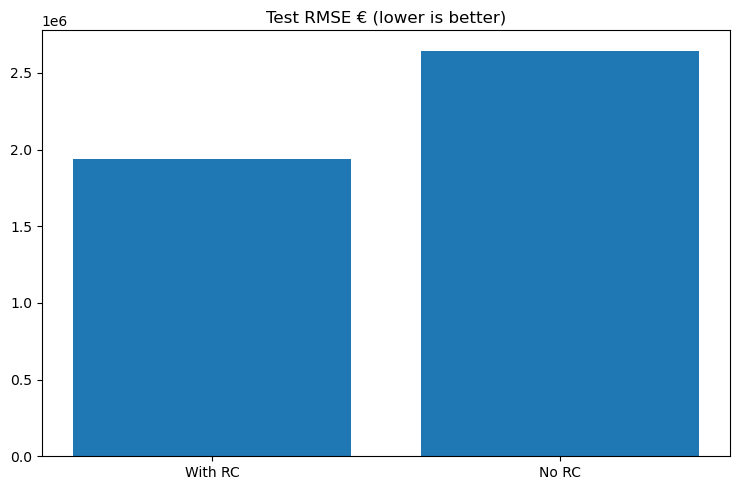

Packaged → deliverables/DataSciencePro_Football_Value_v1.zip


In [20]:
import json, os, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# --- Load metrics from artifacts ---
with open("artifacts/final_test_metrics.json","r",encoding="utf-8") as f:
    m_full = json.load(f)
with open("artifacts/ablation_no_release_clause.json","r",encoding="utf-8") as f:
    m_abl = json.load(f)

# --- Comparison table ---
rows = [
    {
        "model": "RandomForest (with release_clause)",
        "rmse_eur": m_full["eur_smearing"]["rmse"],
        "mae_eur":  m_full["eur_smearing"]["mae"],
        "r2_eur":   m_full["eur_smearing"]["r2"],
    },
    {
        "model": "RandomForest (no release_clause)",
        "rmse_eur": m_abl["eur_smearing"]["rmse"],
        "mae_eur":  m_abl["eur_smearing"]["mae"],
        "r2_eur":   m_abl["eur_smearing"]["r2"],
    },
]
cmp_df = pd.DataFrame(rows)
cmp_df["Δ_RMSE"] = cmp_df["rmse_eur"].diff()
cmp_df["Δ_MAE"]  = cmp_df["mae_eur"].diff()
cmp_df["Δ_R²"]   = cmp_df["r2_eur"].diff()
display(cmp_df.style.format({
    "rmse_eur":"{:,.0f}","mae_eur":"{:,.0f}","r2_eur":"{:.3f}",
    "Δ_RMSE":"{:,.0f}","Δ_MAE":"{:,.0f}","Δ_R²":"{:+.3f}"
}))

# --- Quick charts ---
plt.figure(figsize=(7.5,5))
plt.bar(["With RC","No RC"], [rows[0]["r2_eur"], rows[1]["r2_eur"]])
plt.title("Test R² (EUR, smearing)")
plt.ylim(0,1)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.5,5))
plt.bar(["With RC","No RC"], [rows[0]["rmse_eur"], rows[1]["rmse_eur"]])
plt.title("Test RMSE € (lower is better)")
plt.tight_layout(); plt.show()

lines = []
lines.append("# Football Player Market Value — Regression\n\n")
lines.append("**Final model:** RandomForest (300 trees, sqrt features)\n")
lines.append(f"**Test (log):** RMSE={m_full['log']['rmse']:.3f}, MAE={m_full['log']['mae']:.3f}, R²={m_full['log']['r2']:.3f}\n")
lines.append(f"**Test (EUR, smearing):** RMSE={m_full['eur_smearing']['rmse']:,.0f}, MAE={m_full['eur_smearing']['mae']:,.0f}, R²={m_full['eur_smearing']['r2']:.3f}\n\n")
lines.append("## Ablation (no release_clause)\n")
lines.append(f"Test (EUR): RMSE={m_abl['eur_smearing']['rmse']:,.0f}, MAE={m_abl['eur_smearing']['mae']:,.0f}, R²={m_abl['eur_smearing']['r2']:.3f}\n\n")
lines.append("## Files\n")
lines.append("- artifacts/final_model_pipeline.joblib\n")
lines.append("- artifacts/final_test_metrics.json\n")
lines.append("- artifacts/test_predictions.csv\n")
lines.append("- artifacts/model_no_release_clause.joblib\n")
lines.append("- artifacts/ablation_no_release_clause.json\n")
lines.append("- artifacts/inference_template.csv\n\n")
lines.append("## Quick Inference\n")
lines.append("```python\n")
lines.append("import joblib, json, pandas as pd, numpy as np\n")
lines.append('pipe = joblib.load("artifacts/final_model_pipeline.joblib")\n')
lines.append('smear = json.load(open("artifacts/final_test_metrics.json"))["smear"]\n')
lines.append('df = pd.read_csv("your_data.csv")\n')
lines.append('cols = pd.read_csv("artifacts/inference_template.csv").columns.tolist()\n')
lines.append("y_log = pipe.predict(df[[c for c in cols if c in df.columns]])\n")
lines.append('df["pred_value_eur"] = np.exp(y_log)*smear - 1\n')
lines.append('df.to_csv("predictions.csv", index=False)\n')
lines.append("```\n")
readme = "".join(lines)

os.makedirs("deliverables", exist_ok=True)
with open("deliverables/README.md","w",encoding="utf-8") as f: 
    f.write(readme)

with open("deliverables/requirements.txt","w",encoding="utf-8") as f:
    f.write("pandas\nnumpy\nscikit-learn\nmatplotlib\njoblib\n")

# --- Zip package ---
to_zip = [
    "deliverables/README.md",
    "deliverables/requirements.txt",
    "artifacts/final_model_pipeline.joblib",
    "artifacts/final_test_metrics.json",
    "artifacts/test_predictions.csv",
    "artifacts/model_no_release_clause.joblib",
    "artifacts/ablation_no_release_clause.json",
    "artifacts/inference_template.csv",
    "artifacts/feature_importances.csv",
    "artifacts/val_predictions.csv",
]
zip_path = "deliverables/DataSciencePro_Football_Value_v1.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for p in to_zip:
        if os.path.exists(p):
            z.write(p, arcname=os.path.basename(p))

print("Packaged →", zip_path)
